In [1]:
# Load in libraries

import warnings
warnings.filterwarnings('ignore')

#libraries for handling data
import pandas as pd
import numpy as np
import math
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

#label encoders
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()


#libraries for data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
%matplotlib inline
import seaborn as sns
#sns.set_palette('Set2')
sns.set_color_codes("pastel")

#libaries for modelling
# Regression Modelling Algorithms
import statsmodels.api as sm
#from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor , GradientBoostingRegressor

In [2]:
filepath = "/Users/reejungkim/Documents/Git/Production analysis/Online Retail.xlsx"
pd.ExcelFile(filepath).sheet_names

['Online Retail']

In [3]:
df = pd.read_excel(filepath, sheet_name = 'Online Retail')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
df.CustomerID = df.CustomerID.astype(str)

In [6]:
df.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [7]:
df['TotalPurchase'] = df.Quantity * df.UnitPrice
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPurchase
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


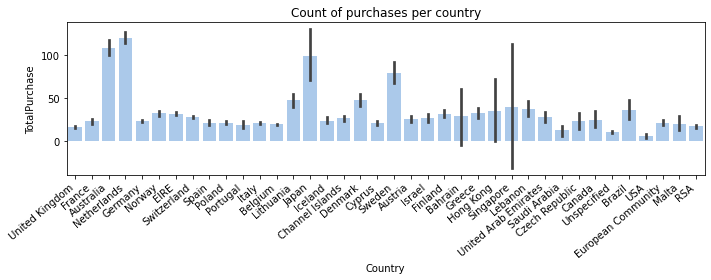

In [8]:
plt.figure(figsize=(10,4))

ax = sns.barplot(x='Country', y='TotalPurchase', color='b', data=df)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title('Count of purchases per country')
plt.tight_layout()
plt.show()

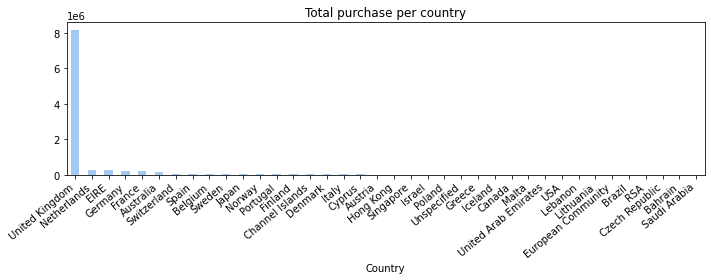

In [9]:
plt.figure(figsize=(10,4))

#ax = sns.barplot(x='Country', y='TotalPurchase', color='b', data=df, estimator=sum)
ax = df.groupby('Country')['TotalPurchase'].sum().sort_values( ascending=False).plot(kind='bar', color='b')

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title('Total purchase per country')
plt.tight_layout()
plt.show()

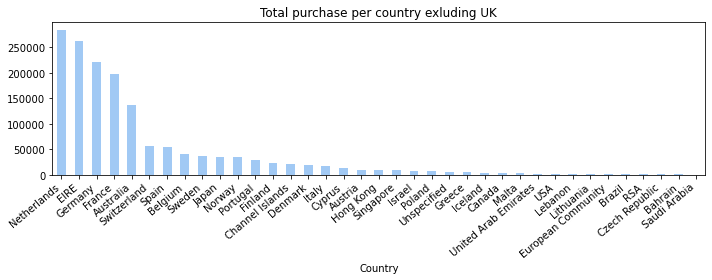

In [10]:
plt.figure(figsize=(10,4))

#ax = sns.barplot(x='Country', y='TotalPurchase', color='b', data=df, estimator=sum)
ax = df.loc[df.Country != 'United Kingdom'].groupby('Country')['TotalPurchase'].sum().sort_values( ascending=False).plot(kind='bar', color='b')

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title('Total purchase per country exluding UK')
plt.tight_layout()
plt.show()

In [11]:
df.groupby('Country')['TotalPurchase'].sum().sort_values(ascending=False)[:5]

Country
United Kingdom    8.187806e+06
Netherlands       2.846615e+05
EIRE              2.632768e+05
Germany           2.216982e+05
France            1.974039e+05
Name: TotalPurchase, dtype: float64

In [12]:
np.sort( df.Country.unique() )

array(['Australia', 'Austria', 'Bahrain', 'Belgium', 'Brazil', 'Canada',
       'Channel Islands', 'Cyprus', 'Czech Republic', 'Denmark', 'EIRE',
       'European Community', 'Finland', 'France', 'Germany', 'Greece',
       'Hong Kong', 'Iceland', 'Israel', 'Italy', 'Japan', 'Lebanon',
       'Lithuania', 'Malta', 'Netherlands', 'Norway', 'Poland',
       'Portugal', 'RSA', 'Saudi Arabia', 'Singapore', 'Spain', 'Sweden',
       'Switzerland', 'USA', 'United Arab Emirates', 'United Kingdom',
       'Unspecified'], dtype=object)

In [17]:
def getAggValuePerCustomer(dataframe):
    data = dataframe.groupby(['CustomerID', 'Country']).agg({
                                        'InvoiceDate': lambda date: (date.max() - date.min()).days,
                                        'InvoiceNo': lambda num: len(num),
                                        'Quantity': lambda quant: quant.sum(),
                                        'TotalPurchase': lambda price: price.sum()})
    data.columns = ['num_days','num_transactions','num_units','spent_money']
    data['avg_order_value'] = data['spent_money']/data['num_transactions']
    data['profit_margin'] = data['spent_money']*0.05   #assume the business has approx 5% profit on the total sale.
    return data

In [18]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPurchase
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


In [20]:
df = getAggValuePerCustomer(df).reset_index()
df

,CustomerID,Country,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin
0,12346.0,United Kingdom,0,2,0,0.00,0.000000,0.0000
1,12347.0,Iceland,365,182,2458,4310.00,23.681319,215.5000
2,12348.0,Finland,282,31,2341,1797.24,57.975484,89.8620
3,12349.0,Italy,0,73,631,1757.55,24.076027,87.8775
4,12350.0,Norway,0,17,197,334.40,19.670588,16.7200
...,...,...,...,...,...,...,...,...
4384,nan,Israel,242,47,363,913.57,19.437660,45.6785
4385,nan,Portugal,0,39,136,307.21,7.877179,15.3605
4386,nan,Switzerland,103,125,547,645.95,5.167600,32.2975
4387,nan,United Kingdom,372,133600,255296,1419932.97,10.628241,70996.6485


In [21]:
#Create data frames for each country

df_name_list = list()

for i in df.Country.unique():
    df_name = "data_" + str(i).replace(" ", "_")
    #print(df_name)
    df_name_list.append(df_name)
    globals()[df_name] = df.loc[df.Country == i]
    
df_name_list

['data_United_Kingdom',
 'data_Iceland',
 'data_Finland',
 'data_Italy',
 'data_Norway',
 'data_Bahrain',
 'data_Spain',
 'data_Portugal',
 'data_Switzerland',
 'data_Austria',
 'data_Cyprus',
 'data_Belgium',
 'data_Unspecified',
 'data_Denmark',
 'data_Australia',
 'data_France',
 'data_Germany',
 'data_RSA',
 'data_Greece',
 'data_Sweden',
 'data_Israel',
 'data_USA',
 'data_Saudi_Arabia',
 'data_Poland',
 'data_United_Arab_Emirates',
 'data_Singapore',
 'data_Japan',
 'data_Netherlands',
 'data_Lebanon',
 'data_Brazil',
 'data_Czech_Republic',
 'data_EIRE',
 'data_Channel_Islands',
 'data_European_Community',
 'data_Lithuania',
 'data_Canada',
 'data_Malta',
 'data_Hong_Kong']

In [22]:
data_United_Kingdom.head(2)

,CustomerID,Country,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin
0,12346.0,United Kingdom,0,2,0,0.00,0.000000,0.0000
337,12747.0,United Kingdom,366,103,1275,4196.01,40.737961,209.8005


#CLTV = ((Average Order Value x Purchase Frequency)/Churn Rate) x Profit margin.
#Customer Value = Average Order Value * Purchase Frequency

In [24]:
def getChurnRates(dataframe):
    purchase_frequency=sum(dataframe['num_transactions'])/dataframe.shape[0]
    repeat_rate =  dataframe[dataframe.num_transactions > 1].shape[0]/dataframe.shape[0]
    churn_rate = churn_rate=1-repeat_rate
    return [ purchase_frequency, repeat_rate, churn_rate]

In [25]:
getChurnRates(data_United_Kingdom)

[125.40572007086813, 0.9807643634522906, 0.019235636547709434]

In [26]:
getChurnRates(data_France)

[97.23863636363636, 1.0, 0.0]

In [27]:
def getCustomerValue(dataframe, purchase_frequency, churn_rate):
    dataframe['CLV'] = dataframe['avg_order_value'] * purchase_frequency / churn_rate
    dataframe['cust_lifetime_value'] = dataframe['CLV'] * dataframe['profit_margin']
    return dataframe

In [35]:
for country in df_name_list:
    indicators = getChurnRates( globals()[country] )
    purchase_frequency = indicators[0]
    churn_rate = indicators[1]
    globals()[country] = getCustomerValue( globals()[country], purchase_frequency, churn_rate )

In [36]:
data_United_Kingdom

,CustomerID,Country,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin,CLV,cust_lifetime_value
0,12346.0,United Kingdom,0,2,0,0.00,0.000000,0.0000,0.000000,0.000000e+00
337,12747.0,United Kingdom,366,103,1275,4196.01,40.737961,209.8005,5208.971232,1.092845e+06
338,12748.0,United Kingdom,372,4642,24210,29072.10,6.262839,1453.6050,800.799764,1.164047e+06
339,12749.0,United Kingdom,209,231,1422,3868.20,16.745455,193.4100,2141.162407,4.141222e+05
384,12820.0,United Kingdom,323,59,722,942.34,15.971864,47.1170,2042.247079,9.622456e+04
...,...,...,...,...,...,...,...,...,...,...
4376,18281.0,United Kingdom,0,7,54,80.82,11.545714,4.0410,1476.296109,5.965713e+03
4377,18282.0,United Kingdom,118,13,98,176.60,13.584615,8.8300,1737.000790,1.533772e+04
4378,18283.0,United Kingdom,333,756,1397,2094.88,2.771005,104.7440,354.315396,3.711241e+04
4379,18287.0,United Kingdom,158,70,1586,1837.28,26.246857,91.8640,3356.062009,3.083013e+05


In [ ]:
df_CLV = getAggValuePerCustomer(df)
purchase_frequency = getChurnRates(df_CLV)[0]
churn_rate = getChurnRates(df_CLV)[2]
df_CLV = getCustomerValue(df_CLV, purchase_frequency, churn_rate)
df_CLV

In [ ]:
df['month_yr'] = df['InvoiceDate'].apply(lambda x: x.strftime('%Y-%m'))

df.sort_values(by='InvoiceDate', ascending=True, inplace=True)

sale = df.pivot_table(index=['CustomerID'],columns=['month_yr'],
                           values='TotalPurchase',aggfunc='sum',fill_value=0).reset_index()

sale

In [ ]:
#summation of customer value of each row across all columns except first two columns(month_yr and CustomerID)
sale['CLV']=sale.iloc[:,2:].sum(axis=1)

In [ ]:
sale.head()

In [ ]:
sale.columns.nunique()

In [ ]:
X = sale.loc[:, (sale.columns != 'CustomerID') & (sale.columns != 'CLV')] 
#sale.iloc[:, 2:sale.columns.nunique()-1]

In [ ]:
y=sale['CLV']

In [ ]:
#split training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

In [ ]:
# import model
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

# make predictions on the testing set
y_pred = linreg.predict(X_test)

In [ ]:
linreg.intercept_

In [ ]:
linreg.coef_

In [ ]:
from sklearn import metrics

# compute the R Square for model
print("R-Square:",metrics.r2_score(y_test, y_pred))

In [ ]:
#calculate MAE using scikit-learn
print("MAE:",metrics.mean_absolute_error(y_test,y_pred))

#calculate mean squared error
print("MSE",metrics.mean_squared_error(y_test, y_pred))
# compute the RMSE of our predictions
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [ ]:
y_pred